In [14]:
import torch
from tqdm import tqdm
from scipy.optimize import linprog
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
train_data = datasets.MNIST(root='data', train=True, download=True)

In [16]:
def filter_data(train_data, digit_1, digit_2):
    digits_cls = torch.tensor([digit_1, digit_2])
    indices = torch.isin(train_data.targets, digits_cls)
    train_data.data = train_data.data[indices]
    train_data.targets = train_data.targets[indices]
    train_data.targets = torch.where(train_data.targets == digit_1, -1, 1)
    return train_data

In [17]:
train_data = filter_data(train_data, 2, 7)

In [18]:
from sklearn.model_selection import train_test_split

def split_dataset(train_data):
    X_train, X_test, y_train, y_test = train_test_split(
        train_data.data, train_data.targets, stratify=train_data.targets, test_size=0.3
    )
    return X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = split_dataset(train_data)

In [20]:
print(f"Number of samples in train: {len(X_train)} \n\
Classes number in train: {torch.sum(y_train == 1)}, {torch.sum(y_train == -1)} \n\
Number of samples in test: {len(X_test)} \n\
Classes number in test: {torch.sum(y_test == 1)}, {torch.sum(y_test == -1)}")

Number of samples in train: 8556 
Classes number in train: 4385, 4171 
Number of samples in test: 3667 
Classes number in test: 1880, 1787


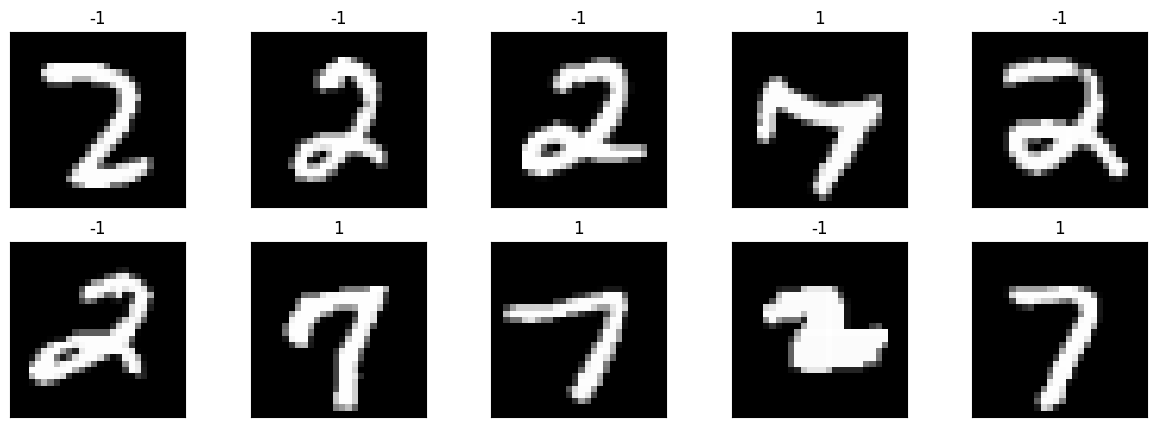

In [21]:
fig = plt.figure(figsize=(15, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[idx].numpy()), cmap='gray')
    ax.set_title(str(y_train[idx].item()))

In [22]:
def prep_data(X_train):
    X = X_train.reshape(X_train.shape[0], -1) / 255.0
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    return X

def initialize_weight_vector(size):
    w = np.random.randn(size) * 0.01
    return w

def misclassified(X, y, W):
    predictions = np.dot(X, W)
    misclassified_indices = np.where(np.sign(predictions) != y)[0]
    return misclassified_indices

X_train_flat_aug = prep_data(X_train)
W = initialize_weight_vector(X_train_flat_aug.shape[1])
misclassified_indices = misclassified(X_train_flat_aug, y_train, W)

In [23]:
def train_perceptron(X, y, iterations=1000, learning_rate=1.0):
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    W = np.random.rand(X.shape[1]) * 0.01  

    for i in range(iterations):
        misclass_indices = misclassified(X, y, W)
        if len(misclass_indices) == 0:
            print(f"Found separating hyperplane on step {i}!")
            break
        
        random_index = np.random.choice(misclass_indices)
        W += learning_rate * y[random_index] * X[random_index]

    return W

W = train_perceptron(X_train_flat_aug, y_train)


In [24]:
def evaluate_classifier(X, y, W):
    predictions = np.sign(np.dot(X, W))
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

X_test_flat_aug = prep_data(X_test)

performance_metrics = evaluate_classifier(X_test_flat_aug, y_test, W)
print(performance_metrics)


{'accuracy': 0.9833651486228525, 'precision': 0.9774278215223097, 'recall': 0.9904255319148936, 'f1_score': 0.9838837516512549}
